

---

# **Chord Extractor using MLP & Viterbi Algorithm**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup codes

In [ ]:
import numpy as np
import pandas as pd
import os
import nltk
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from collections import OrderedDict
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines

In [ ]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  
device = torch.device('cuda:0')

Good to go!


1. Chord templates
2. Chord dictionaries (for embedding)
3. Path declaration
4. File declaration

In [ ]:
np.set_printoptions(linewidth=np.inf)

pcp = ['A(bass)', 'Bb(bass)', 'B(bass)', 'C(bass)', 'C#(bass)', 'D(bass)', 'Eb(bass)', 'E(bass)', 'F(bass)', 'F#(bass)', 'G(bass)', 'Ab(bass)', 'A', 'Bb', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab']

chord2index = {'N': 0, 'B#:maj': 1, 'C:maj': 1, 'C#:maj': 2, 'Db:maj': 2, 'D:maj': 3, 'D#:maj': 4, 'Eb:maj': 4, 'E:maj': 5, 'Fb:maj': 5, 'E#:maj': 6, 'F:maj': 6, 'F#:maj': 7, 'Gb:maj': 7, 'G:maj': 8, 'G#:maj': 9, 'Ab:maj': 9, 'A:maj': 10, 'A#:maj': 11, 'Bb:maj': 11, 'B:maj': 12, 'Cb:maj': 12, 'B#:min': 13, 'C:min': 13, 'C#:min': 14, 'Db:min': 14, 'D:min': 15, 'D#:min': 16, 'Eb:min': 16, 'E:min': 17, 'Fb:min': 17, 'E#:min': 18, 'F:min': 18, 'F#:min': 19, 'Gb:min': 19, 'G:min': 20, 'G#:min': 21, 'Ab:min': 21, 'A:min': 22, 'A#:min': 23, 'Bb:min': 23, 'B:min': 24, 'Cb:min': 24, 'X': 25}
index2chord = {0: 'N', 1: 'C:maj', 2: 'C#:maj', 3: 'D:maj', 4: 'Eb:maj', 5: 'E:maj', 6: 'F:maj', 7: 'F#:maj', 8: 'G:maj', 9: 'Ab:maj', 10: 'A:maj', 11: 'Bb:maj', 12: 'B:maj', 13: 'C:min', 14: 'C#:min', 15: 'D:min', 16: 'Eb:min', 17: 'E:min', 18: 'F:min', 19: 'F#:min', 20: 'G:min', 21: 'Ab:min', 22: 'A:min', 23: 'Bb:min', 24: 'B:min', 25: 'X'}

num_chords = len(index2chord)

chroma_path = '/content/drive/MyDrive/ML Project/McGill-Billboard-2.0-chordino/'
chord_path = '/content/drive/MyDrive/ML Project/McGill-Billboard-2.0-mirex/'

files = os.listdir(chroma_path)

batch_size = 64
print_every = 5000
num_pcp = len(pcp)
smax = 110000

random.seed(1)

Load tensor objects.

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/ML Project/data/all.tar')

# General data
file_infos = checkpoint['file_infos']
train_files = checkpoint['train_files']
validation_files = checkpoint['validation_files']
test_files = checkpoint['test_files']

# Task 1: MLP data
train_chroma_samples = checkpoint['train_chroma_samples']
train_chord_labels = checkpoint['train_chord_labels']
validation_chroma_samples = checkpoint['validation_chroma_samples']
validation_chord_labels = checkpoint['validation_chord_labels']
test_chroma_samples = checkpoint['test_chroma_samples']
test_chord_labels = checkpoint['test_chord_labels']
splitted_train_data = checkpoint['splitted_train_data']

# Task 1: Viterbi data
transition_matrix = checkpoint['transition_matrix']

# Task 2: LSTM data
train_chord_sequences = checkpoint['train_chord_sequences'] 
validation_chord_sequences = checkpoint['validation_chord_sequences']
test_chord_sequences = checkpoint['test_chord_sequences']

In [ ]:
sampled_train_data = [[] for i in range(num_chords)]
for i in range(num_chords):
  sampled = splitted_train_data[i]
  if len(splitted_train_data[i]) > smax:
    sampled = random.sample(sampled, smax)
  sampled_train_data[i] = sampled

train_data_final = []
for sampled in sampled_train_data:
  train_data_final += sampled
train_data_final = torch.stack(train_data_final, dim=0)

sampled_train_chroma_samples = train_data_final[:, :-1]
sampled_train_chord_labels = F.one_hot(train_data_final[:, -1].to(dtype=torch.int64), num_classes=num_chords)

In [ ]:
for i in range(num_chords):
  print('{:2} {:8} chord has {:6} samples'.format(i, '('+index2chord[i]+')', len(sampled_train_data[i])))

# Task 1: MLP

In [ ]:
def get_chroma_chord_data(file):
  chroma_tensors = []
  chord_tensors = []

  chroma_data = open(chroma_path + file + '/bothchroma.csv', 'r')
  chord_data = open(chord_path + file + '/majmin.lab', 'r')

  chord_line = chord_data.readline()

  start_end_chord = chord_line.split()
  end = float(start_end_chord[1])
  for chroma_line in chroma_data:
    time_chroma = chroma_line.split(',')
    t = float(time_chroma[1])
    if t > end:
      chord_line = chord_data.readline()
      if not chord_line: break
      start_end_chord = chord_line.split()
      if len(start_end_chord) < 3: break
      end = float(start_end_chord[1])

    chroma = time_chroma[2:]
    chroma[-1] = chroma[-1][:-1]
    chroma = list(map(float, chroma))
    chord = start_end_chord[2]
    chroma_tensors.append(torch.tensor(chroma, dtype = torch.float32, device = device))
    chord_tensors.append(torch.tensor([chord2index[chord]], dtype = torch.int64, device = device))

  chroma_data.close()
  chord_data.close()

  chroma_samples = torch.stack(chroma_tensors, dim=0)
  chord_labels = F.one_hot(torch.cat(chord_tensors, dim=0), num_classes=num_chords)
  return chroma_samples, chord_labels

In [ ]:
def check_accuracy_MLP(model, loader):
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      scores = model(x)
      preds = scores.argmax(1)
      targets = y.argmax(1)
      num_correct += (preds == targets).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc), end = ' ')
  return acc

In [ ]:
def train_MLP(model, train_loader, optimizer, validation_loader=None, epochs=1):
    model = model.to(device=device)
    acc = 0
    for e in range(epochs):
        print('Epoch {}/{} ===================================================================================================================================='.format(e+1, epochs))
        for t, (x, y) in enumerate(train_loader):
            model.train()

            scores = model(x)
            loss = F.cross_entropy(scores, y.to(dtype=torch.float32))

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                if validation_loader:
                  acc = check_accuracy_MLP(model, validation_loader)
                print()
    return acc

In [ ]:
hidden_size_1 = 32
hidden_size_2 = 64
hidden_size_3 = 128

Chord_Extractor_MLP = nn.Sequential(OrderedDict([
  ('layer1', nn.Linear(num_pcp, hidden_size_1)),
  ('bn1', nn.BatchNorm1d(hidden_size_1)),
  ('relu1', nn.ReLU()),
  ('drop1', nn.Dropout(0.1)),
  ('layer2', nn.Linear(hidden_size_1, hidden_size_2)),
  ('bn2', nn.BatchNorm1d(hidden_size_2)),
  ('relu2', nn.ReLU()),
  ('drop2', nn.Dropout(0.1)),
  ('layer3', nn.Linear(hidden_size_2, hidden_size_3)),
  ('bn3', nn.BatchNorm1d(hidden_size_3)),
  ('relu3', nn.ReLU()),
  ('drop3', nn.Dropout(0.1)),
  ('final', nn.Linear(hidden_size_3, num_chords)),
  ('softmax', nn.Softmax(1))
]))

In [ ]:
#train_dataset = torch.utils.data.TensorDataset(sampled_train_chroma_samples, sampled_train_chord_labels)
train_dataset = torch.utils.data.TensorDataset(train_chroma_samples, train_chord_labels) # for ver0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = torch.utils.data.TensorDataset(validation_chroma_samples, validation_chord_labels)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_dataset = torch.utils.data.TensorDataset(test_chroma_samples, test_chord_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-4

optimizer = optim.Adam(Chord_Extractor_MLP.parameters(), lr=learning_rate, weight_decay = weight_decay)

train_MLP(Chord_Extractor_MLP, train_loader, optimizer, validation_loader=validation_loader, epochs=5)

In [ ]:
torch.save({'model': Chord_Extractor_MLP
}, '/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver6.tar')

In [ ]:
checkpoint_MLP_ver0 = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver0.tar')
Chord_Extractor_MLP_ver0 = checkpoint_MLP_ver0['model'].to(device=device)

checkpoint_MLP_ver1 = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver1.tar')
Chord_Extractor_MLP_ver1 = checkpoint_MLP_ver1['model'].to(device=device)

checkpoint_MLP_ver2 = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver2.tar')
Chord_Extractor_MLP_ver2 = checkpoint_MLP_ver2['model'].to(device=device)

checkpoint_MLP_ver3 = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver3.tar')
Chord_Extractor_MLP_ver3 = checkpoint_MLP_ver3['model'].to(device=device)

checkpoint_MLP_ver4 = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver4.tar')
Chord_Extractor_MLP_ver4 = checkpoint_MLP_ver4['model'].to(device=device)

checkpoint_MLP_ver5 = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver5.tar')
Chord_Extractor_MLP_ver5 = checkpoint_MLP_ver5['model'].to(device=device)

checkpoint_MLP_ver6 = torch.load('/content/drive/MyDrive/ML Project/data/Chord_Extractor_MLP_ver6.tar')
Chord_Extractor_MLP_ver6 = checkpoint_MLP_ver6['model'].to(device=device)

In [ ]:
print("Version 0 Validation Accuracy:", end = ' ')
check_accuracy_MLP(Chord_Extractor_MLP_ver0, validation_loader)
print()

print("Version 1 Validation Accuracy:", end = ' ')
check_accuracy_MLP(Chord_Extractor_MLP_ver1, validation_loader)
print()

print("Version 2 Validation Accuracy:", end = ' ')
check_accuracy_MLP(Chord_Extractor_MLP_ver2, validation_loader)
print()

print("Version 3 Validation Accuracy:", end = ' ')
check_accuracy_MLP(Chord_Extractor_MLP_ver3, validation_loader)
print()

print("Version 4 Validation Accuracy:", end = ' ')
check_accuracy_MLP(Chord_Extractor_MLP_ver4, validation_loader)
print()

print("Version 5 Validation Accuracy:", end = ' ')
check_accuracy_MLP(Chord_Extractor_MLP_ver5, validation_loader)
print()

print("Version 6 Validation Accuracy:", end = ' ')
check_accuracy_MLP(Chord_Extractor_MLP_ver6, validation_loader)
print()

Version 0 Validation Accuracy: Got 143872 / 257653 correct (55.84) 
Version 1 Validation Accuracy: Got 148935 / 257653 correct (57.80) 
Version 2 Validation Accuracy: Got 148484 / 257653 correct (57.63) 
Version 3 Validation Accuracy: Got 146694 / 257653 correct (56.93) 
Version 4 Validation Accuracy: Got 146664 / 257653 correct (56.92) 
Version 5 Validation Accuracy: Got 153933 / 257653 correct (59.74) 
Version 6 Validation Accuracy: Got 146932 / 257653 correct (57.03) 


# Task 1: MLP + Viterbi

In [ ]:
def Chord_Extractor_Viterbi(P0):
  len_song = P0.shape[0]

  delta = torch.zeros(len_song, num_chords, device=device)
  psi = torch.zeros(len_song, num_chords, device=device)
  
  delta[0, :] = (1/num_pcp) * P0[0, :]
  for t in range(1, len_song):
    delta[t, :], _ =torch.max(delta[t-1:t, :] * transition_matrix.T * P0[t:t+1, :].T, dim=1)
    psi[t, :] = torch.argmax(delta[t-1:t, :] * transition_matrix.T, dim=1)
    max_del, _ = torch.max(delta[t, :], dim=0)
    while max_del.item() < 0.01:
      delta[t, :] *= 10
      max_del, _ = torch.max(delta[t, :], dim=0)

  processed = torch.zeros(len_song, dtype=torch.int64, device=device)
  processed[len_song-1] = torch.argmax(delta[len_song-1, :])
  for t in range(len_song - 1, 0, -1):
    processed[t - 1] = psi[t, processed[t]]
  return processed

In [ ]:
def check_accuracy_Viterbi(files, model):
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for file in tqdm(files):
      chroma_samples, targets = get_chroma_chord_data(file)
      P0 = model(chroma_samples)
      preds = Chord_Extractor_Viterbi(P0)
      num_correct += (preds == targets.argmax(1)).sum()
      num_samples += preds.shape[0]
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc), end = ' ')
    return acc

In [ ]:
print("Version 0 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi(validation_files, Chord_Extractor_MLP_ver0)
print()

print("Version 1 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi(validation_files, Chord_Extractor_MLP_ver1)
print()

print("Version 2 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi(validation_files, Chord_Extractor_MLP_ver2)
print()

print("Version 3 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi(validation_files, Chord_Extractor_MLP_ver3)
print()

print("Version 4 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi(validation_files, Chord_Extractor_MLP_ver4)
print()

print("Version 5 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi(validation_files, Chord_Extractor_MLP_ver5)
print()

print("Version 6 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi(validation_files, Chord_Extractor_MLP_ver6)
print()

Version 0 Validation Accuracy: 

100%|██████████| 59/59 [00:56<00:00,  1.04it/s]


Got 149614 / 257653 correct (58.07) 
Version 1 Validation Accuracy: 

100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


Got 160913 / 257653 correct (62.45) 
Version 2 Validation Accuracy: 

100%|██████████| 59/59 [00:59<00:00,  1.00s/it]


Got 159146 / 257653 correct (61.77) 
Version 3 Validation Accuracy: 

100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Got 155913 / 257653 correct (60.51) 
Version 4 Validation Accuracy: 

100%|██████████| 59/59 [00:58<00:00,  1.00it/s]


Got 154693 / 257653 correct (60.04) 
Version 5 Validation Accuracy: 

100%|██████████| 59/59 [00:57<00:00,  1.02it/s]


Got 163420 / 257653 correct (63.43) 
Version 6 Validation Accuracy: 

100%|██████████| 59/59 [00:57<00:00,  1.02it/s]

Got 154146 / 257653 correct (59.83) 


# Task 1: MLP + CCS (Chord Change Sensing)

In [ ]:
def Chord_Extractor_CCS(chroma_samples, preds_0, threshold = 1.0):
  preds = preds_0.clone()
  
  file_length = preds.shape[0]
  for i in range(1, file_length):
    if preds[i] != preds[i-1] and torch.dist(chroma_samples[i], chroma_samples[i - 1]).item() > threshold:
      preds[i] = preds[i-1]
  
  return preds

In [ ]:
def check_accuracy_CCS(files, model, threshold = 1.0):
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for file in tqdm(files):
      chroma_samples, targets = get_chroma_chord_data(file)
      preds_0 = model(chroma_samples).argmax(1)
      preds = Chord_Extractor_CCS(chroma_samples, preds_0, threshold)
      num_correct += (preds == targets.argmax(1)).sum()
      num_samples += preds.shape[0]
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc), end = ' ')
    return acc

In [ ]:
print("Version 0 Validation Accuracy:", end = ' ')
check_accuracy_CCS(validation_files, Chord_Extractor_MLP_ver0)
print()

print("Version 1 Validation Accuracy:", end = ' ')
check_accuracy_CCS(validation_files, Chord_Extractor_MLP_ver1)
print()

print("Version 2 Validation Accuracy:", end = ' ')
check_accuracy_CCS(validation_files, Chord_Extractor_MLP_ver2)
print()

print("Version 3 Validation Accuracy:", end = ' ')
check_accuracy_CCS(validation_files, Chord_Extractor_MLP_ver3)
print()

print("Version 4 Validation Accuracy:", end = ' ')
check_accuracy_CCS(validation_files, Chord_Extractor_MLP_ver4)
print()

print("Version 5 Validation Accuracy:", end = ' ')
check_accuracy_CCS(validation_files, Chord_Extractor_MLP_ver5)
print()

print("Version 6 Validation Accuracy:", end = ' ')
check_accuracy_CCS(validation_files, Chord_Extractor_MLP_ver6, 1.0)
print()

Version 0 Validation Accuracy: 

100%|██████████| 59/59 [00:21<00:00,  2.75it/s]


Got 146471 / 257653 correct (56.85) 
Version 1 Validation Accuracy: 

100%|██████████| 59/59 [00:23<00:00,  2.53it/s]


Got 152642 / 257653 correct (59.24) 
Version 2 Validation Accuracy: 

100%|██████████| 59/59 [00:21<00:00,  2.68it/s]


Got 151986 / 257653 correct (58.99) 
Version 3 Validation Accuracy: 

100%|██████████| 59/59 [00:22<00:00,  2.67it/s]


Got 150245 / 257653 correct (58.31) 
Version 4 Validation Accuracy: 

100%|██████████| 59/59 [00:21<00:00,  2.72it/s]


Got 149749 / 257653 correct (58.12) 
Version 5 Validation Accuracy: 

100%|██████████| 59/59 [00:21<00:00,  2.72it/s]


Got 157298 / 257653 correct (61.05) 
Version 6 Validation Accuracy: 

100%|██████████| 59/59 [00:22<00:00,  2.60it/s]

Got 149611 / 257653 correct (58.07) 


# Task 1: MLP + Viterbi + CCS

In [ ]:
def check_accuracy_Viterbi_CCS(files, model, threshold = 1.0):
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for file in tqdm(files):
      chroma_samples, targets = get_chroma_chord_data(file)
      P0 = model(chroma_samples)
      preds_0 = Chord_Extractor_Viterbi(P0)
      preds = Chord_Extractor_CCS(chroma_samples, preds_0, threshold)
      num_correct += (preds == targets.argmax(1)).sum()
      num_samples += preds.shape[0]
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc), end = ' ')
    return acc

In [ ]:
print("Version 0 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver0)
print()

print("Version 1 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver1)
print()

print("Version 2 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver2)
print()

print("Version 3 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver3)
print()

print("Version 4 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver4)
print()

print("Version 5 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver5)
print()

print("Version 6 Validation Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver6)
print()

Version 0 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.10s/it]


Got 151457 / 257653 correct (58.78) 
Version 1 Validation Accuracy: 

100%|██████████| 59/59 [01:08<00:00,  1.15s/it]


Got 163565 / 257653 correct (63.48) 
Version 2 Validation Accuracy: 

100%|██████████| 59/59 [01:06<00:00,  1.13s/it]


Got 161579 / 257653 correct (62.71) 
Version 3 Validation Accuracy: 

100%|██████████| 59/59 [01:07<00:00,  1.14s/it]


Got 158469 / 257653 correct (61.50) 
Version 4 Validation Accuracy: 

100%|██████████| 59/59 [01:05<00:00,  1.11s/it]


Got 156922 / 257653 correct (60.90) 
Version 5 Validation Accuracy: 

100%|██████████| 59/59 [01:05<00:00,  1.12s/it]


Got 165724 / 257653 correct (64.32) 
Version 6 Validation Accuracy: 

100%|██████████| 59/59 [01:06<00:00,  1.12s/it]

Got 156248 / 257653 correct (60.64) 


In [ ]:
for i in range(5, 31):
  print("Threshold = {:.1f} Validation Accuracy:".format(i/10), end = ' ')
  check_accuracy_Viterbi_CCS(validation_files, Chord_Extractor_MLP_ver5, threshold = i/10)
  print()

Threshold = 0.5 Validation Accuracy: 

100%|██████████| 59/59 [01:10<00:00,  1.20s/it]


Got 149084 / 257653 correct (57.86) 
Threshold = 0.6 Validation Accuracy: 

100%|██████████| 59/59 [01:18<00:00,  1.33s/it]


Got 158879 / 257653 correct (61.66) 
Threshold = 0.7 Validation Accuracy: 

100%|██████████| 59/59 [01:07<00:00,  1.14s/it]


Got 163220 / 257653 correct (63.35) 
Threshold = 0.8 Validation Accuracy: 

100%|██████████| 59/59 [01:07<00:00,  1.15s/it]


Got 165371 / 257653 correct (64.18) 
Threshold = 0.9 Validation Accuracy: 

100%|██████████| 59/59 [01:24<00:00,  1.43s/it]


Got 165966 / 257653 correct (64.41) 
Threshold = 1.0 Validation Accuracy: 

100%|██████████| 59/59 [01:05<00:00,  1.12s/it]


Got 165724 / 257653 correct (64.32) 
Threshold = 1.1 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.10s/it]


Got 166081 / 257653 correct (64.46) 
Threshold = 1.2 Validation Accuracy: 

100%|██████████| 59/59 [01:10<00:00,  1.19s/it]


Got 166064 / 257653 correct (64.45) 
Threshold = 1.3 Validation Accuracy: 

100%|██████████| 59/59 [01:07<00:00,  1.14s/it]


Got 165830 / 257653 correct (64.36) 
Threshold = 1.4 Validation Accuracy: 

100%|██████████| 59/59 [01:03<00:00,  1.08s/it]


Got 165616 / 257653 correct (64.28) 
Threshold = 1.5 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.09s/it]


Got 165555 / 257653 correct (64.26) 
Threshold = 1.6 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.09s/it]


Got 165329 / 257653 correct (64.17) 
Threshold = 1.7 Validation Accuracy: 

100%|██████████| 59/59 [01:03<00:00,  1.08s/it]


Got 165110 / 257653 correct (64.08) 
Threshold = 1.8 Validation Accuracy: 

100%|██████████| 59/59 [01:03<00:00,  1.07s/it]


Got 164942 / 257653 correct (64.02) 
Threshold = 1.9 Validation Accuracy: 

100%|██████████| 59/59 [01:03<00:00,  1.08s/it]


Got 164721 / 257653 correct (63.93) 
Threshold = 2.0 Validation Accuracy: 

100%|██████████| 59/59 [01:09<00:00,  1.18s/it]


Got 164537 / 257653 correct (63.86) 
Threshold = 2.1 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.10s/it]


Got 164325 / 257653 correct (63.78) 
Threshold = 2.2 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.10s/it]


Got 164206 / 257653 correct (63.73) 
Threshold = 2.3 Validation Accuracy: 

100%|██████████| 59/59 [01:03<00:00,  1.08s/it]


Got 164038 / 257653 correct (63.67) 
Threshold = 2.4 Validation Accuracy: 

100%|██████████| 59/59 [01:07<00:00,  1.14s/it]


Got 163908 / 257653 correct (63.62) 
Threshold = 2.5 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.09s/it]


Got 163804 / 257653 correct (63.58) 
Threshold = 2.6 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.09s/it]


Got 163721 / 257653 correct (63.54) 
Threshold = 2.7 Validation Accuracy: 

100%|██████████| 59/59 [01:08<00:00,  1.15s/it]


Got 163640 / 257653 correct (63.51) 
Threshold = 2.8 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.09s/it]


Got 163573 / 257653 correct (63.49) 
Threshold = 2.9 Validation Accuracy: 

100%|██████████| 59/59 [01:04<00:00,  1.10s/it]


Got 163536 / 257653 correct (63.47) 
Threshold = 3.0 Validation Accuracy: 

100%|██████████| 59/59 [01:06<00:00,  1.13s/it]

Got 163500 / 257653 correct (63.46) 


# Compare the accuracy of models by file

In [ ]:
def check_accuracy_file(file, model, viterbi = True, ccs = True, threshold = 1.0):
  model.eval()
  with torch.no_grad():
    chroma_samples, targets = get_chroma_chord_data(file)
    P0 = model(chroma_samples)

    if viterbi:
      preds_0 = Chord_Extractor_Viterbi(P0)
    else:
      preds_0 = P0.argmax(1)
    
    if ccs:
      preds = Chord_Extractor_CCS(chroma_samples, preds_0, threshold)
    else:
      preds = preds_0

    num_correct = (preds == targets.argmax(1)).sum()
    num_samples = preds.shape[0]
    acc = float(num_correct) / num_samples
    print('%.2f%%' % (100 * acc), end = ' ')
    return acc

In [ ]:
def check_accuracy_ver(file, model, threshold=1.0):
  print("(MLP):", end = '')
  check_accuracy_file(file, model, viterbi = False, ccs = False, threshold = threshold)
  print("(MLP + Viterbi):", end = '')
  check_accuracy_file(file, model, viterbi =  True, ccs = False, threshold = threshold)
  print("(MLP + CCS):", end = '')
  check_accuracy_file(file, model, viterbi = False, ccs =  True, threshold = threshold)
  print("(MLP + Viterbi + CCS):", end = '')
  check_accuracy_file(file, model, viterbi =  True, ccs =  True, threshold = threshold)
  print()

In [ ]:
for file in validation_files:
  print("file #{}".format(file))

  print("Version 0 =>", end = ' ')
  check_accuracy_ver(file, Chord_Extractor_MLP_ver0)

  print("Version 1 =>", end = ' ')
  check_accuracy_ver(file, Chord_Extractor_MLP_ver1)

  print("Version 2 =>", end = ' ')
  check_accuracy_ver(file, Chord_Extractor_MLP_ver2)

  print("Version 3 =>", end = ' ')
  check_accuracy_ver(file, Chord_Extractor_MLP_ver3)

  print("Version 4 =>", end = ' ')
  check_accuracy_ver(file, Chord_Extractor_MLP_ver4)

  print("Version 5 =>", end = ' ')
  check_accuracy_ver(file, Chord_Extractor_MLP_ver5)

  print("Version 6 =>", end = ' ')
  check_accuracy_ver(file, Chord_Extractor_MLP_ver6)

  print()


file #0787
Version 0 => (MLP):76.89% (MLP + Viterbi):79.54% (MLP + CCS):76.48% (MLP + Viterbi + CCS):78.52% 
Version 1 => (MLP):65.83% (MLP + Viterbi):70.39% (MLP + CCS):67.84% (MLP + Viterbi + CCS):71.31% 
Version 2 => (MLP):70.15% (MLP + Viterbi):74.81% (MLP + CCS):71.20% (MLP + Viterbi + CCS):75.39% 
Version 3 => (MLP):71.44% (MLP + Viterbi):76.48% (MLP + CCS):71.51% (MLP + Viterbi + CCS):76.96% 
Version 4 => (MLP):76.48% (MLP + Viterbi):80.26% (MLP + CCS):76.82% (MLP + Viterbi + CCS):80.60% 
Version 5 => (MLP):75.12% (MLP + Viterbi):79.34% (MLP + CCS):75.77% (MLP + Viterbi + CCS):79.17% 
Version 6 => (MLP):79.31% (MLP + Viterbi):82.64% (MLP + CCS):78.28% (MLP + Viterbi + CCS):82.13% 

file #0250
Version 0 => (MLP):57.74% (MLP + Viterbi):61.62% (MLP + CCS):56.68% (MLP + Viterbi + CCS):62.22% 
Version 1 => (MLP):62.57% (MLP + Viterbi):69.89% (MLP + CCS):62.72% (MLP + Viterbi + CCS):70.08% 
Version 2 => (MLP):64.92% (MLP + Viterbi):70.43% (MLP + CCS):66.25% (MLP + Viterbi + CCS):70.58

In [ ]:
validation_files_accuracy = {'0787': [[76.89, 79.54, 76.48, 78.52], [65.83, 70.39, 67.84, 71.31], [70.15, 74.81, 71.20, 75.39], [71.44, 76.48, 71.51, 76.96], [76.48, 80.26, 76.82, 80.60], [75.12, 79.34, 75.77, 79.17], [79.31, 82.64, 78.28, 82.13]],
'0250': [[57.74, 61.62, 56.68, 62.22], [62.57, 69.89, 62.72, 70.08], [64.92, 70.43, 66.25, 70.58], [64.35, 70.84, 66.44, 71.41], [58.62, 61.85, 58.54, 61.85], [59.91, 65.41, 61.16, 66.70], [60.21, 63.59, 59.61, 63.33]],
'0500': [[73.25, 80.04, 79.01, 82.45], [52.80, 65.90, 58.81, 68.04], [56.58, 69.44, 60.30, 71.91], [53.75, 65.20, 59.11, 69.07], [48.26, 56.49, 53.87, 59.35], [57.65, 67.34, 64.47, 70.23], [66.61, 75.81, 71.27, 78.31]],
'0308': [[76.22, 81.02, 77.83, 81.18], [56.91, 66.42, 63.32, 69.40], [54.43, 62.78, 60.84, 66.91], [57.03, 64.23, 63.69, 67.12], [70.31, 76.30, 71.75, 76.72], [68.44, 74.57, 71.42, 75.60], [70.97, 77.25, 72.91, 77.87]],
'0790': [[73.30, 75.23, 74.65, 76.13], [75.02, 78.82, 77.16, 79.99], [74.50, 78.58, 76.04, 79.51], [76.83, 80.45, 78.30, 81.32], [79.78, 82.62, 81.02, 83.46], [78.52, 81.32, 80.08, 82.74], [69.52, 71.91, 71.00, 72.93]],
'0807': [[70.92, 73.29, 71.69, 74.26], [72.78, 77.76, 73.85, 78.87], [72.59, 78.58, 73.58, 79.89], [71.84, 74.83, 73.01, 75.71], [74.88, 77.35, 76.11, 78.88], [73.44, 76.27, 74.37, 77.06], [72.62, 75.10, 73.89, 76.05]],
'0758': [[83.01, 84.24, 81.90, 83.05], [79.78, 83.82, 78.97, 82.64], [78.90, 84.14, 78.36, 83.42], [80.60, 85.78, 79.07, 84.80], [79.88, 83.40, 79.14, 82.34], [84.21, 87.68, 83.37, 86.62], [84.36, 87.19, 83.20, 86.37]],
'1078': [[24.22, 25.63, 23.53, 24.90], [24.88, 25.83, 25.55, 26.06], [24.52, 26.38, 24.84, 26.43], [24.39, 26.02, 24.43, 26.02], [24.09, 25.72, 22.95, 24.65], [25.98, 27.39, 25.23, 25.76], [23.19, 24.86, 22.74, 25.05]],
'0147': [[78.54, 81.88, 79.93, 83.42], [63.88, 68.57, 66.92, 70.86], [65.94, 69.84, 68.90, 72.73], [66.99, 71.01, 69.32, 72.84], [73.29, 78.81, 76.97, 81.43], [71.23, 75.43, 73.52, 77.83], [72.36, 76.03, 75.17, 78.99]],
'0229': [[54.39, 58.26, 58.64, 60.61], [37.07, 40.46, 39.75, 43.42], [35.82, 41.10, 38.27, 42.89], [38.07, 43.32, 41.02, 46.28], [51.35, 57.29, 55.18, 59.28], [47.22, 52.91, 51.68, 56.48], [48.42, 52.24, 52.75, 54.13]],
'0442': [[11.93, 12.34, 11.27, 11.49], [46.59, 51.36, 42.52, 48.55], [37.41, 39.42, 33.48, 36.73], [13.29, 13.73, 12.53, 12.81], [11.60, 11.86, 10.64, 10.81], [12.90, 13.54, 12.57, 13.00], [12.63, 12.98, 12.15, 12.11]],
'0324': [[70.59, 72.34, 72.42, 73.38], [64.50, 69.11, 69.37, 72.19], [64.91, 68.40, 69.67, 70.74], [63.42, 66.10, 67.55, 68.88], [65.50, 70.00, 69.52, 72.23], [67.29, 70.56, 70.48, 72.86], [70.45, 72.60, 73.23, 74.35]],
'0917': [[57.24, 58.14, 57.15, 58.51], [63.71, 68.17, 63.88, 68.91], [64.39, 68.40, 64.27, 68.54], [65.38, 68.99, 65.69, 69.56], [71.48, 74.17, 71.20, 74.00], [67.64, 70.86, 67.16, 71.54], [66.56, 69.05, 66.08, 69.22]],
'0341': [[41.58, 42.76, 42.41, 43.90], [70.39, 73.15, 70.30, 73.20], [55.57, 57.10, 55.40, 57.84], [59.89, 62.43, 60.26, 64.08], [45.85, 47.49, 46.24, 48.38], [71.83, 74.78, 72.11, 75.33], [44.94, 46.27, 45.78, 47.22]],
'1061': [[49.63, 50.76, 50.37, 51.83], [56.05, 58.69, 57.02, 59.00], [54.01, 57.14, 55.29, 58.12], [52.87, 55.01, 53.65, 55.87], [51.49, 53.77, 53.15, 54.72], [58.17, 60.53, 58.56, 60.55], [48.26, 49.58, 48.82, 49.76]],
'0458': [[54.48, 58.76, 56.51, 59.19], [40.12, 46.96, 45.31, 50.53], [40.89, 47.52, 46.92, 50.76], [41.77, 46.08, 47.45, 49.01], [44.40, 48.85, 47.20, 49.97], [46.61, 52.25, 51.36, 54.79], [46.85, 52.74, 51.27, 54.93]],
'0331': [[1.67, 1.62, 1.65, 1.52], [28.03, 32.77, 26.51, 32.27], [24.66, 27.86, 24.91, 27.43], [19.03, 19.33, 18.03, 19.33], [1.85, 2.07, 1.85, 2.04], [10.87, 9.70, 11.20, 9.58], [1.72, 1.60, 1.72, 1.55]],
'0821': [[83.99, 84.77, 84.16, 84.92], [77.86, 81.77, 79.14, 82.31], [80.12, 82.79, 81.09, 83.62], [81.73, 83.20, 82.45, 83.94], [83.14, 83.90, 83.47, 84.58], [84.86, 86.94, 84.48, 87.20], [82.35, 83.07, 82.82, 83.65]],
'0853': [[66.85, 71.47, 69.55, 74.43], [51.22, 58.16, 52.06, 58.00], [51.53, 58.48, 51.64, 58.56], [51.98, 56.55, 52.11, 56.50], [55.31, 61.70, 56.81, 63.58], [59.69, 66.90, 61.97, 68.86], [65.32, 71.32, 66.85, 73.85]],
'0752': [[56.87, 58.10, 57.62, 58.41], [59.03, 63.06, 60.07, 63.75], [61.33, 64.07, 62.67, 64.96], [61.02, 64.40, 62.42, 65.64], [58.67, 61.21, 59.99, 61.96], [61.79, 64.55, 62.99, 65.27], [58.98, 59.91, 59.06, 59.96]],
'0841': [[66.22, 69.64, 68.97, 72.57], [38.95, 41.17, 42.14, 43.48], [31.85, 32.42, 34.73, 34.18], [34.24, 33.40, 36.66, 35.33], [52.60, 59.10, 56.24, 59.54], [46.96, 51.42, 49.93, 51.73], [71.42, 78.03, 73.95, 81.65]],
'1150': [[45.41, 48.50, 44.00, 48.14], [28.17, 32.21, 28.08, 32.53], [25.08, 26.97, 25.24, 27.10], [30.28, 33.48, 28.92, 33.35], [36.96, 39.94, 36.14, 39.75], [39.85, 43.75, 38.39, 42.37], [38.73, 41.62, 37.44, 41.16]],
'0027': [[70.61, 74.94, 72.99, 76.41], [53.56, 59.40, 57.47, 61.94], [51.00, 56.10, 55.33, 58.77], [52.98, 57.24, 57.26, 59.54], [57.07, 61.94, 60.42, 64.70], [60.66, 66.82, 64.29, 68.64], [68.78, 75.27, 72.75, 76.87]],
'0600': [[65.55, 66.95, 64.75, 65.55], [74.11, 78.33, 73.67, 77.31], [76.75, 81.69, 75.97, 79.65], [79.85, 83.67, 78.89, 82.01], [78.41, 81.17, 77.89, 80.13], [77.01, 80.09, 77.07, 77.97], [64.53, 66.29, 63.53, 64.95]],
'0242': [[68.04, 69.53, 69.21, 70.72], [74.32, 76.14, 76.18, 77.81], [70.05, 71.69, 71.92, 73.34], [60.30, 61.34, 61.93, 62.85], [67.16, 67.72, 68.77, 69.35], [64.29, 65.33, 66.11, 66.89], [67.71, 69.02, 69.07, 70.35]],
'0474': [[62.01, 64.08, 62.88, 65.23], [55.56, 59.52, 57.07, 59.63], [57.65, 61.21, 59.24, 63.11], [58.37, 61.44, 58.53, 62.72], [62.31, 64.87, 62.70, 66.08], [60.39, 63.36, 61.24, 63.42], [62.98, 64.82, 64.18, 65.85]],
'0549': [[47.61, 50.94, 46.84, 50.74], [58.48, 63.74, 59.33, 66.26], [66.73, 72.15, 67.14, 73.03], [48.48, 51.89, 46.97, 50.67], [48.65, 52.19, 47.34, 51.65], [63.20, 69.02, 64.85, 70.30], [51.78, 55.12, 51.14, 54.11]],
'0149': [[82.33, 82.68, 82.01, 82.43], [75.14, 78.42, 74.82, 78.60], [77.70, 79.97, 77.87, 80.12], [78.31, 80.58, 77.99, 80.62], [80.10, 81.50, 80.18, 81.06], [80.20, 81.86, 79.66, 81.55], [78.86, 80.89, 78.21, 80.24]],
'1007': [[70.92, 71.46, 70.92, 71.14], [85.82, 89.85, 85.80, 89.31], [87.38, 90.40, 87.51, 89.83], [86.87, 89.57, 87.08, 89.23], [88.02, 90.38, 87.97, 89.59], [86.97, 89.74, 87.95, 90.27], [85.29, 87.42, 86.08, 87.40]],
'0672': [[42.99, 47.05, 46.18, 48.05], [29.25, 33.57, 31.82, 34.61], [33.11, 37.06, 35.30, 37.89], [32.36, 36.28, 34.11, 37.24], [36.82, 41.04, 39.23, 43.31], [38.97, 44.31, 41.16, 45.62], [42.29, 45.66, 44.25, 46.89]],
'1124': [[63.77, 65.76, 66.63, 68.23], [58.71, 63.71, 61.02, 67.30], [58.96, 63.34, 62.34, 67.04], [60.18, 64.62, 61.69, 66.85], [61.04, 64.27, 63.19, 66.74], [61.26, 65.74, 64.25, 68.47], [62.19, 64.62, 64.08, 66.93]],
'0792': [[56.34, 62.03, 57.92, 62.03], [31.33, 37.38, 31.56, 36.98], [32.77, 39.38, 32.87, 39.55], [36.19, 44.87, 36.72, 44.05], [48.78, 56.61, 49.08, 56.18], [45.13, 54.14, 44.44, 53.25], [53.25, 60.59, 53.75, 61.34]],
'0101': [[44.21, 47.08, 44.59, 47.16], [47.54, 52.84, 48.96, 52.95], [44.77, 49.44, 45.00, 48.91], [43.55, 46.60, 44.39, 46.70], [46.09, 48.20, 46.04, 48.53], [43.17, 47.69, 43.32, 47.79], [44.13, 46.95, 44.57, 47.61]],
'0086': [[55.36, 56.59, 57.49, 58.71], [66.40, 70.03, 68.04, 71.25], [65.00, 67.67, 65.84, 68.33], [61.89, 64.25, 63.93, 66.02], [63.13, 66.03, 64.38, 67.18], [67.37, 70.17, 69.44, 72.02], [56.73, 58.72, 57.77, 60.02]],
'0070': [[36.54, 39.62, 37.83, 40.01], [40.04, 43.06, 42.53, 45.18], [40.15, 43.15, 42.09, 45.53], [40.33, 43.68, 42.27, 45.86], [40.06, 43.15, 41.01, 44.53], [40.27, 44.36, 41.62, 45.62], [34.04, 36.54, 36.16, 37.92]],
'1211': [[55.39, 57.23, 56.58, 57.65], [77.28, 83.99, 79.15, 84.38], [76.12, 81.54, 76.94, 81.63], [72.69, 78.41, 74.65, 79.27], [57.29, 60.50, 59.03, 61.39], [74.86, 79.52, 76.24, 79.67], [56.40, 58.08, 57.65, 59.06]],
'0740': [[79.26, 81.36, 80.63, 82.86], [66.41, 73.17, 66.88, 73.61], [68.02, 73.46, 68.87, 73.70], [68.64, 73.05, 70.54, 73.67], [70.42, 75.31, 70.92, 75.13], [72.64, 77.76, 73.90, 78.70], [74.11, 77.97, 74.40, 79.20]],
'0179': [[72.38, 76.94, 73.62, 77.16], [67.39, 77.37, 68.14, 77.55], [71.65, 77.84, 72.72, 78.49], [72.07, 77.11, 73.16, 77.30], [71.07, 75.21, 71.80, 75.94], [70.36, 74.16, 70.68, 74.35], [78.57, 81.73, 79.32, 82.20]],
'0446': [[84.57, 87.18, 82.88, 85.15], [76.94, 81.63, 75.32, 80.01], [79.15, 83.72, 78.04, 81.73], [79.68, 83.02, 78.48, 81.34], [80.48, 83.06, 79.42, 81.50], [82.60, 86.08, 81.06, 84.23], [84.36, 87.86, 82.62, 85.43]],
'0191': [[55.07, 57.32, 58.63, 60.68], [46.34, 50.90, 51.64, 54.51], [49.05, 52.36, 54.38, 56.07], [49.74, 53.00, 57.04, 58.17], [54.99, 58.78, 59.86, 62.42], [54.15, 56.91, 58.78, 61.47], [55.58, 58.12, 60.24, 62.21]],
'0605': [[12.51, 12.78, 13.03, 13.43], [54.48, 58.62, 53.38, 57.84], [59.92, 65.49, 59.23, 65.26], [54.62, 58.72, 53.57, 58.37], [53.17, 57.29, 53.59, 57.88], [49.35, 53.20, 48.86, 53.55], [44.96, 47.88, 44.47, 48.00]],
'0465': [[68.70, 71.17, 67.49, 70.13], [66.10, 72.11, 65.89, 71.86], [67.38, 72.53, 66.63, 71.97], [68.81, 72.91, 68.60, 72.76], [69.82, 73.21, 69.37, 72.73], [72.11, 76.35, 70.97, 75.49], [69.42, 72.82, 68.59, 71.83]],
'0334': [[21.59, 22.47, 22.70, 23.76], [45.06, 50.17, 48.04, 53.11], [49.31, 53.21, 52.60, 56.32], [42.29, 46.58, 44.46, 48.94], [20.78, 23.22, 22.45, 25.30], [44.23, 48.02, 46.94, 50.98], [19.95, 21.18, 21.01, 22.72]],
'1218': [[73.74, 74.70, 73.50, 74.03], [70.54, 73.82, 69.67, 72.82], [71.65, 75.20, 72.05, 74.40], [73.66, 76.15, 73.85, 75.46], [75.22, 77.13, 74.43, 76.07], [75.01, 77.05, 75.28, 76.57], [72.82, 75.04, 72.42, 74.17]],
'1044': [[40.61, 42.04, 42.78, 43.85], [64.55, 68.86, 69.60, 73.01], [64.83, 67.98, 68.89, 70.79], [61.61, 64.52, 65.93, 68.29], [55.05, 56.84, 58.84, 60.21], [59.97, 63.37, 64.77, 67.19], [42.56, 43.99, 44.54, 45.77]],
'1027': [[19.40, 21.47, 17.95, 21.04], [33.93, 38.69, 33.11, 39.67], [33.77, 38.15, 32.50, 38.62], [33.83, 37.07, 34.14, 36.93], [30.10, 32.54, 30.81, 33.18], [30.39, 34.54, 29.19, 34.23], [21.02, 23.61, 22.10, 24.07]],
'0577': [[71.51, 74.88, 76.76, 78.92], [47.48, 52.71, 51.48, 54.37], [48.74, 54.57, 53.83, 56.31], [54.10, 61.29, 58.99, 64.46], [69.90, 74.52, 74.22, 77.94], [62.38, 69.27, 67.58, 73.29], [67.80, 72.42, 71.62, 76.30]],
'0809': [[74.81, 75.40, 75.64, 76.71], [82.66, 86.59, 84.83, 87.83], [81.44, 85.25, 81.38, 85.84], [83.05, 86.11, 83.28, 86.70], [70.35, 72.67, 70.79, 73.88], [85.16, 87.69, 86.47, 89.23], [87.18, 88.58, 88.01, 89.62]],
'0728': [[40.32, 42.46, 41.13, 43.40], [47.62, 51.21, 48.83, 52.88], [41.73, 46.01, 42.57, 45.78], [44.24, 46.55, 44.88, 47.05], [45.31, 48.93, 44.78, 49.33], [41.90, 45.51, 41.63, 45.88], [43.84, 46.65, 44.61, 47.09]],
'0332': [[65.68, 67.55, 70.01, 71.72], [60.17, 64.55, 65.77, 70.06], [60.58, 64.50, 64.51, 69.19], [58.05, 61.53, 62.56, 66.36], [63.43, 66.67, 68.46, 71.06], [64.50, 67.40, 68.94, 71.53], [66.63, 69.09, 71.97, 74.43]],
'0670': [[58.40, 59.20, 58.88, 59.57], [72.70, 75.87, 73.94, 76.58], [72.12, 75.14, 72.96, 76.02], [73.58, 76.34, 74.33, 76.88], [73.24, 75.23, 74.34, 75.82], [70.60, 72.84, 71.87, 73.51], [63.30, 64.59, 63.99, 64.94]],
'0434': [[58.97, 59.58, 58.65, 58.74], [66.72, 69.60, 66.66, 68.72], [60.92, 62.87, 60.63, 61.85], [59.29, 61.50, 59.00, 60.75], [62.73, 65.03, 62.41, 64.15], [62.90, 65.35, 62.73, 64.44], [61.42, 64.33, 60.34, 62.84]],
'0779': [[56.46, 57.83, 57.91, 58.94], [59.78, 63.56, 61.43, 65.43], [61.10, 64.48, 63.69, 66.07], [62.24, 64.78, 64.31, 65.74], [61.15, 62.94, 63.36, 64.70], [63.78, 65.04, 66.24, 66.91], [57.66, 59.75, 59.22, 61.01]],
'0546': [[21.10, 22.12, 24.26, 24.63], [36.35, 38.58, 39.90, 41.23], [36.86, 39.28, 40.22, 43.15], [34.04, 36.41, 39.02, 40.33], [16.28, 17.27, 19.00, 19.83], [32.31, 33.40, 35.90, 36.93], [19.45, 20.69, 22.17, 23.53]],
'0212': [[61.99, 68.54, 60.82, 67.43], [41.93, 49.80, 41.33, 46.91], [46.43, 53.97, 45.22, 51.64], [46.33, 53.59, 45.37, 51.47], [49.80, 56.20, 49.90, 54.78], [54.43, 61.71, 51.82, 58.02], [55.97, 62.16, 55.34, 60.67]],
'1161': [[49.10, 50.67, 50.36, 51.65], [62.72, 66.89, 65.27, 69.07], [65.55, 68.71, 68.43, 71.57], [65.06, 68.59, 67.97, 71.03], [46.84, 48.30, 47.35, 49.67], [65.73, 69.43, 68.77, 72.01], [57.33, 59.82, 59.02, 60.93]],
'0925': [[45.25, 47.87, 46.88, 49.90], [56.07, 62.37, 59.21, 66.31], [48.90, 53.53, 51.27, 56.35], [50.46, 54.56, 52.52, 56.19], [46.50, 49.52, 48.73, 52.01], [52.97, 57.31, 55.59, 60.67], [46.40, 48.73, 47.96, 50.79]],
'0650': [[39.11, 40.62, 38.20, 39.71], [59.44, 64.19, 60.23, 65.73], [57.90, 61.99, 59.85, 62.71], [59.85, 63.47, 60.38, 64.07], [59.91, 61.80, 60.70, 61.89], [58.97, 62.43, 59.25, 63.06], [48.21, 49.78, 47.70, 49.18]],
'0377': [[61.13, 69.22, 66.02, 70.46], [58.72, 66.60, 61.74, 68.92], [57.79, 65.57, 61.74, 66.99], [61.77, 71.09, 64.45, 71.58], [65.12, 71.82, 68.04, 73.39], [62.19, 71.15, 64.15, 73.20], [67.11, 73.02, 69.58, 74.47]]}

# Plot

In [ ]:
def plot_graph(file, model, viterbi = True, ccs = True, threshold = 1.0):  
  delta_t = 2048/44100
  chroma_samples, chord_labels = get_chroma_chord_data(file)
  length = chord_labels.shape[0]
  X = np.arange(length) * delta_t

  model.eval()
  with torch.no_grad():
    P0 = model(chroma_samples)
    if viterbi:
      preds_0 = Chord_Extractor_Viterbi(P0)
    else:
      preds_0 = P0.argmax(1)
    if ccs:
      preds = Chord_Extractor_CCS(chroma_samples, preds_0, threshold = threshold)
    else:
      preds = preds_0
  targets = chord_labels.argmax(1)
  
  fig = plt.figure(figsize=(20, 8))
  plt.scatter(X, targets.cpu(), c='#ffc0cb', s=130, marker = 's', edgecolor=None, label = 'Ground Truth Chord')
  plt.scatter(X, preds.cpu(), c='#3ec5f1', marker = 's', edgecolor=None, label = 'Estimated Chord')
  plt.xlabel('Time (s)', fontsize=18)
  plt.ylabel('Chord Types', fontsize=18)
  plt.title('Estimated Chords for file #' + file, fontsize=24)
  plt.yticks(np.arange(num_chords), labels=index2chord.values())
  plt.xlim(- 3, length * delta_t + 3)
  plt.ylim(-1.0, 26.0)
  plt.grid(True, axis='both')
  plt.legend(loc=1, framealpha=0.6)
  plt.show()

In [ ]:
def plot_graph_prec(file, model, viterbi = True, ccs = True, threshold = 1.0, cut = [0.0, 1.0]):
  g_size = 1.2
  e_size = 0.4
  delta_t = 2048/44100
  chroma_samples, chord_labels = get_chroma_chord_data(file)
  length = chord_labels.shape[0]
  start = int(length * cut[0])
  end = int(length * cut[1])
  fig, ax = plt.subplots(figsize=(20, 8))
  ax.set_xlim(start * delta_t - 3, end * delta_t + 3)
  ax.set_ylim(-1.0, 26.0)

  model.eval()
  with torch.no_grad():
    P0 = model(chroma_samples)
    if viterbi:
      preds_0 = Chord_Extractor_Viterbi(P0)
    else:
      preds_0 = P0.argmax(1)
    if ccs:
      preds = Chord_Extractor_CCS(chroma_samples, preds_0, threshold = threshold).cpu()
    else:
      preds = preds_0.cpu()
  targets = chord_labels.argmax(1).cpu()

  for i in range(length):
    ax.add_patch(patches.Rectangle((i * delta_t, targets[i] - g_size/2), delta_t, g_size, facecolor = '#ffc0cb'))
    ax.add_patch(patches.Rectangle((i * delta_t,   preds[i] - e_size/2), delta_t, e_size, facecolor = '#3ec5f1'))
  plt.xlabel('Time (s)', fontsize=18)
  plt.ylabel('Chord Types', fontsize=18)
  plt.title('Estimated Chords for file #' + file, fontsize=24)
  plt.yticks(np.arange(num_chords), labels=index2chord.values())
  plt.grid(True, axis='both')
  legend_lines = [mlines.Line2D([], [], color='#ffc0cb', marker='s'),
                  mlines.Line2D([], [], color='#3ec5f1', marker='s')]
  plt.legend(legend_lines, ['Ground Truth Chord', 'Estimated Chord'], loc=1, framealpha=0.6)
  plt.show()

In [ ]:
def plot_graph_corr(file, model, viterbi = True, ccs = True, threshold = 1.0, cut = [0.0, 1.0]):
  g_size = 1.2
  e_size = 0.4
  delta_t = 2048/44100
  chroma_samples, chord_labels = get_chroma_chord_data(file)
  length = chord_labels.shape[0]
  start = int(length * cut[0])
  end = int(length * cut[1])
  fig, ax = plt.subplots(figsize=(20, 8))
  ax.set_xlim(start * delta_t - 3, end * delta_t + 3)
  ax.set_ylim(-1.0, 26.0)

  model.eval()
  with torch.no_grad():
    P0 = model(chroma_samples)
    if viterbi:
      preds_0 = Chord_Extractor_Viterbi(P0)
    else:
      preds_0 = P0.argmax(1)
    if ccs:
      preds = Chord_Extractor_CCS(chroma_samples, preds_0, threshold = threshold).cpu()
    else:
      preds = preds_0.cpu()
  targets = chord_labels.argmax(1).cpu()

  for i in range(start, end):
    ax.add_patch(patches.Rectangle((i * delta_t, targets[i] - g_size/2), delta_t, g_size, facecolor = '#ffc0cb'))
    if preds[i] == targets[i]: facecolor = '#3ec5f1'
    else: facecolor = '#ffff00'
    ax.add_patch(patches.Rectangle((i * delta_t,   preds[i] - e_size/2), delta_t, e_size, facecolor = facecolor))
  plt.xlabel('Time (s)', fontsize=18)
  plt.ylabel('Chord Types', fontsize=18)
  plt.title('Estimated Chords for file #' + file, fontsize=24)
  plt.yticks(np.arange(num_chords), labels=index2chord.values())
  plt.grid(True, axis='both')
  legend_lines = [mlines.Line2D([], [], color='#ffc0cb', marker='s'),
                  mlines.Line2D([], [], color='#3ec5f1', marker='s'),
                  mlines.Line2D([], [], color='#ffff00', marker='s')]
  plt.legend(legend_lines, ['Ground Truth Chord', 'Estimated Chord (Correct)', 'Estimated Chord (Wrong)'], loc=1, framealpha=0.6)
  plt.show()

In [ ]:
def plot_graph_diff(file, models, viterbi = [False, True], ccs = [False, True], threshold = [1.0, 1.0], cut = [0.0, 1.0]):
  g_size = 1.2
  e_size = 0.4
  delta_t = 2048/44100
  chroma_samples, chord_labels = get_chroma_chord_data(file)
  length = chord_labels.shape[0]
  start = int(length * cut[0])
  end = int(length * cut[1])
  fig, ax = plt.subplots(figsize=(20, 8))
  ax.set_xlim(start * delta_t - 3, end * delta_t + 3)
  ax.set_ylim(-1.0, 26.0)

  models[0].eval()
  models[1].eval()
  with torch.no_grad():
    P0 = models[0](chroma_samples)
    if viterbi[0]:
      preds_0 = Chord_Extractor_Viterbi(P0)
    else:
      preds_0 = P0.argmax(1)
    if ccs[0]:
      preds1 = Chord_Extractor_CCS(chroma_samples, preds_0, threshold = threshold[0]).cpu()
    else:
      preds1 = preds_0.cpu()
    P0 = models[1](chroma_samples)
    if viterbi[1]:
      preds_0 = Chord_Extractor_Viterbi(P0)
    else:
      preds_0 = P0.argmax(1)
    if ccs[1]:
      preds2 = Chord_Extractor_CCS(chroma_samples, preds_0, threshold = threshold[1]).cpu()
    else:
      preds2 = preds_0.cpu()
  targets = chord_labels.argmax(1).cpu()

  for i in range(start, end):
    ax.add_patch(patches.Rectangle((i * delta_t, targets[i] - g_size/2), delta_t, g_size, facecolor = '#ffc0cb'))
    if preds1[i] == targets[i]: facecolor = '#3ec5f1'
    elif preds2[i] == targets[i]: facecolor = '#80d038'
    else: facecolor = '#ffff00'
    ax.add_patch(patches.Rectangle((i * delta_t,   preds2[i] - e_size/2), delta_t, e_size, facecolor = facecolor))
  plt.xlabel('Time (s)', fontsize=18)
  plt.ylabel('Chord Types', fontsize=18)
  plt.title('Estimated Chords for file #' + file, fontsize=24)
  plt.yticks(np.arange(num_chords), labels=index2chord.values())
  plt.grid(True, axis='both')
  legend_lines = [mlines.Line2D([], [], color='#ffc0cb', marker='s'),
                  mlines.Line2D([], [], color='#3ec5f1', marker='s'),
                  mlines.Line2D([], [], color='#80d038', marker='s'),
                  mlines.Line2D([], [], color='#ffff00', marker='s')]
  plt.legend(legend_lines, ['Ground Truth Chord', 'Estimated Chord (Original Correct)', 'Estimated Chord (New Correct)', 'Estimated Chord (Still Wrong)'], loc=1, framealpha=0.6)
  plt.show()

In [ ]:
def plot_chord_change(file, model, viterbi = True, ccs = False, threshold = 1.0, cut = [0.0, 1.0]):
  chroma_samples, chord_labels = get_chroma_chord_data(file)
  dists = []
  preds_chord_indices = dict()
  targets_chord_indices = dict()
  length = chord_labels.shape[0]
  start = int(length * cut[0])
  end = int(length * cut[1])
  
  model.eval()
  with torch.no_grad():
    P0 = model(chroma_samples)
    if viterbi:
      preds_0 = Chord_Extractor_Viterbi(P0)
    else:
      preds_0 = P0.argmax(1)
    if ccs:
      preds = Chord_Extractor_CCS(chroma_samples, preds_0, threshold)
    else:
      preds = preds_0
  
  for i in range(end):
    dists.append(torch.dist(chroma_samples[i], chroma_samples[i - 1]).item())
    if i < start:
      continue
    curr_preds = preds[i]
    prev_preds = preds[i-1]
    if curr_preds != prev_preds:
      preds_chord_indices[i] = (prev_preds.item(), curr_preds.item())
    curr_target = torch.argmax(chord_labels[i])
    prev_target = torch.argmax(chord_labels[i-1])
    if curr_target != prev_target:
      targets_chord_indices[i] = (prev_target.item(), curr_target.item())
  
  print('Predicted chord change :', preds_chord_indices)
  print('   Actual chord change :', targets_chord_indices)
  
  total_chord_indices = sorted(set(targets_chord_indices.keys()).union(set(preds_chord_indices.keys())))

  plt.figure(figsize=(30,8))
  plt.xticks(total_chord_indices, fontsize=16)
  plt.yticks(fontsize=16)
  plt.axhline(y=2, color='r', linewidth=1)
  plt.axhline(y=1, color='g', linewidth=1)

  for index in preds_chord_indices:
      plt.axvline(x=index, ls='--', color = 'yellow')
  
  for index in targets_chord_indices:
      plt.axvline(x=index, ls='--', color = 'black')

  plt.plot(np.arange(start, end), dists[start:end], 'b')
  plt.xlabel('Chromavector Index', fontsize=18)
  plt.ylabel('Distance', fontsize=18)
  plt.title('Distance between the current chromavector and the previous chromavector for file #' + file, fontsize=24)
  legend_lines = [mlines.Line2D([], [], color='yellow'),
                  mlines.Line2D([], [], color='black')]
  plt.legend(legend_lines, ['Predicted Chord Change', 'Actual Chord Change'], loc=1, fontsize=16, framealpha=0.6)
  plt.show()

# MLP Best

In [ ]:
max = 0
ans = 0
for file in validation_files_accuracy:  
  for i in range(7):
    acc = validation_files_accuracy[file][0][0]
    if acc > max:
      max = acc
      ans = file
print(ans, max)

0446 84.57


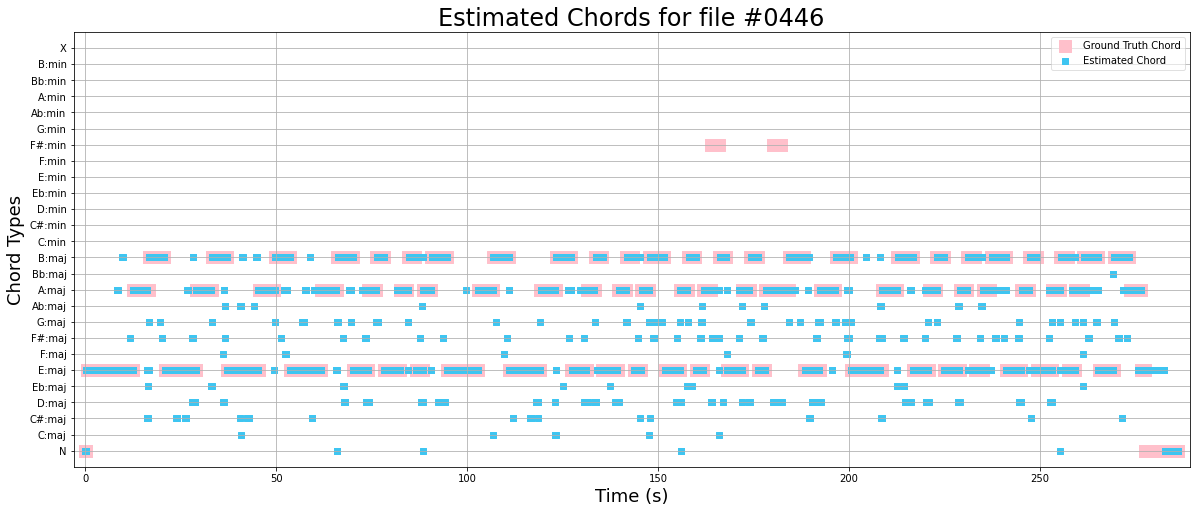

84.57% 


In [ ]:
plot_graph('0446', Chord_Extractor_MLP_ver0, viterbi = False, ccs = False)
check_accuracy_file('0446', Chord_Extractor_MLP_ver0, viterbi = False, ccs = False)
print()

# Highest Increase by Sampling

In [ ]:
max = 0
ans = (0, 0, 0, 0, 0)
for file in validation_files_accuracy:  
  for i in range(1, 7):
    before = validation_files_accuracy[file][0][0]
    after = validation_files_accuracy[file][i][0]
    diff = after - before
    if diff > max:
      max = diff
      ans = (file, i, before, after, max)
print(ans)

('0605', 2, 12.51, 59.92, 47.410000000000004)


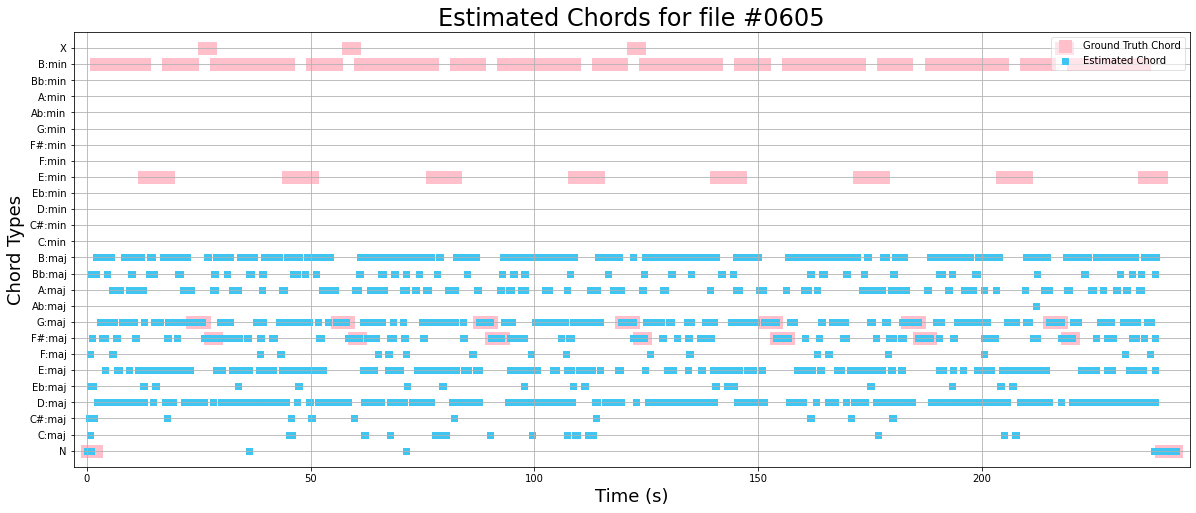

12.51% 


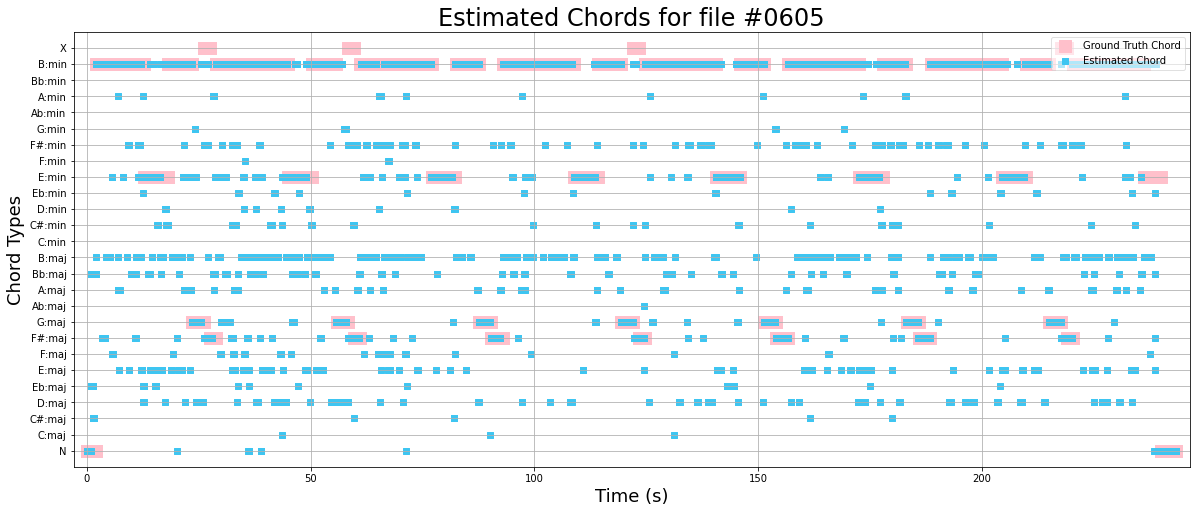

59.92% 


In [ ]:
plot_graph('0605', Chord_Extractor_MLP_ver0, viterbi = False, ccs = False)
check_accuracy_file('0605', Chord_Extractor_MLP_ver0, viterbi = False, ccs = False)
print()

plot_graph('0605', Chord_Extractor_MLP_ver2, viterbi = False, ccs = False)
check_accuracy_file('0605', Chord_Extractor_MLP_ver2, viterbi = False, ccs = False)
print()

# Highest Increase by Viterbi

In [ ]:
max = 0
ans = (0, 0, 0, 0, 0)
for file in validation_files_accuracy:  
  for i in range(7):
    before = validation_files_accuracy[file][i][0]
    after = validation_files_accuracy[file][i][1]
    diff = after - before
    if diff > max:
      max = diff
      ans = (file, i, before, after, max)
print(ans)

('0500', 1, 52.8, 65.9, 13.100000000000009)


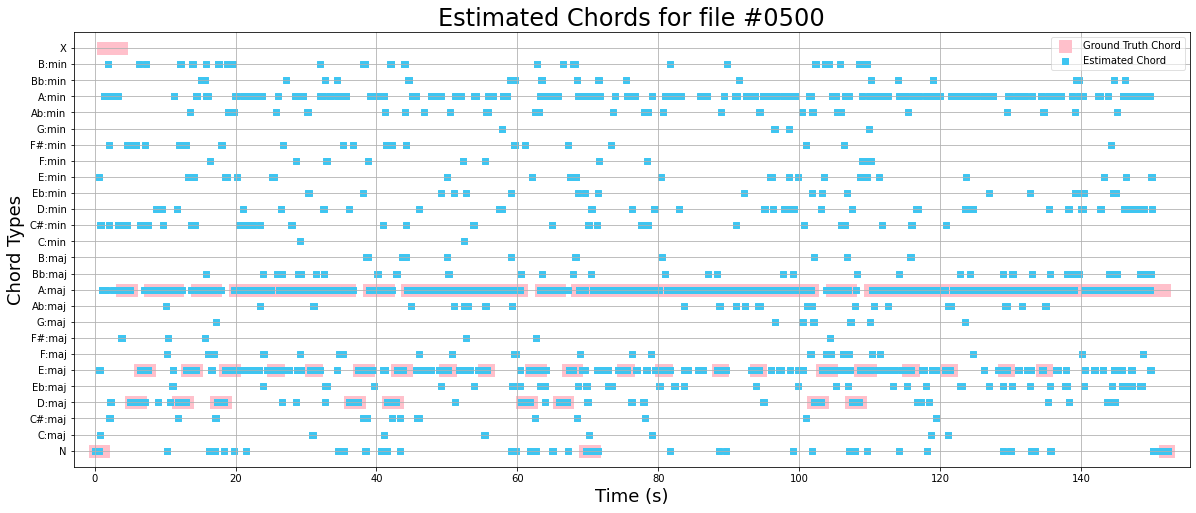

52.80% 


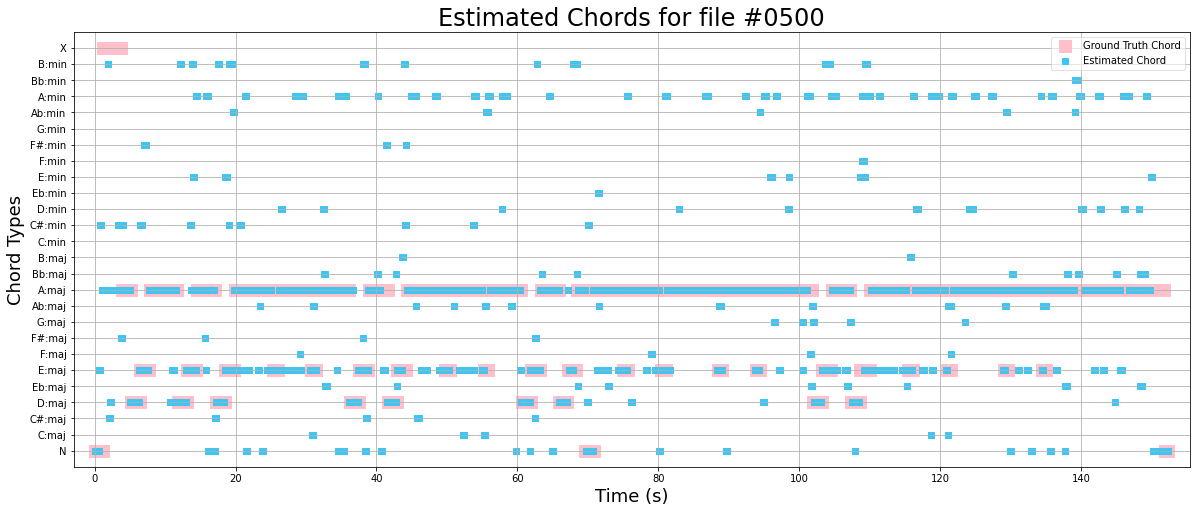

65.90% 


In [ ]:
plot_graph('0500', Chord_Extractor_MLP_ver1, viterbi = False, ccs = False)
check_accuracy_file('0500', Chord_Extractor_MLP_ver1, viterbi = False, ccs = False)
print()

plot_graph('0500', Chord_Extractor_MLP_ver1, viterbi = True, ccs = False)
check_accuracy_file('0500', Chord_Extractor_MLP_ver1, viterbi = True, ccs = False)
print()

# Highest Increase by CCS

In [ ]:
max = 0
ans = (0, 0, 0, 0, 0)
for file in validation_files_accuracy:  
  for i in range(7):
    before = validation_files_accuracy[file][i][1]
    after = validation_files_accuracy[file][i][3]
    diff = after - before
    if diff > max:
      max = diff
      ans = (file, i, before, after, max)
print(ans)

('0332', 1, 64.55, 70.06, 5.510000000000005)


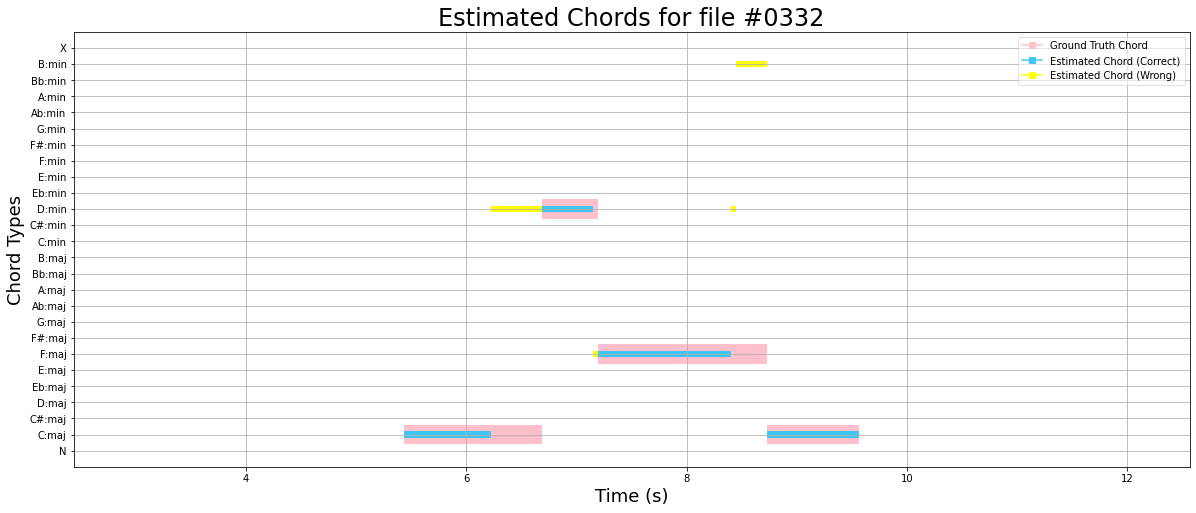

In [ ]:
plot_graph_corr('0332', Chord_Extractor_MLP_ver1, viterbi = True, ccs = False, cut = [0.02, 0.035])

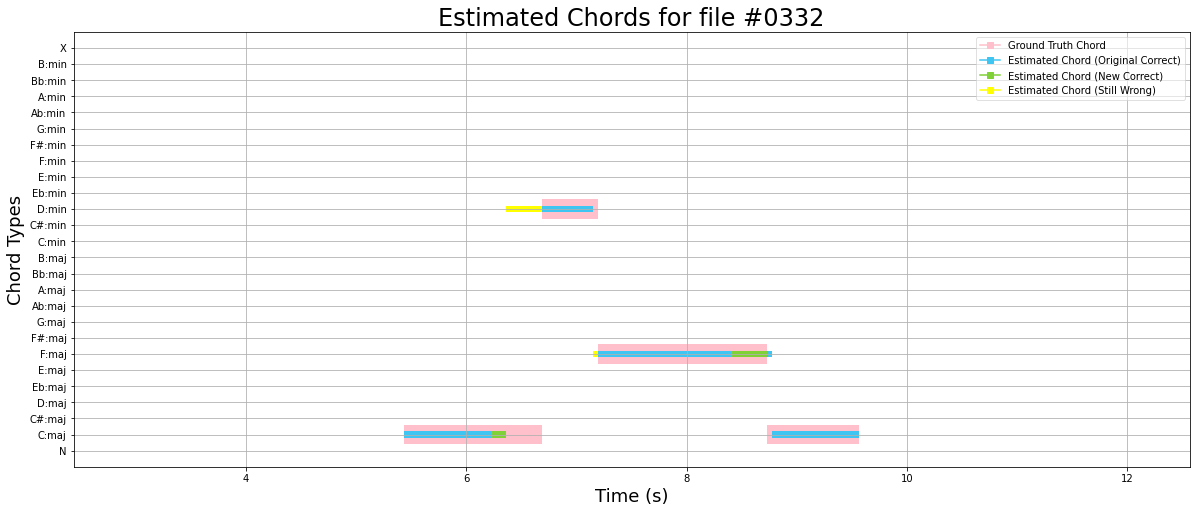

In [ ]:
plot_graph_diff('0332', [Chord_Extractor_MLP_ver1, Chord_Extractor_MLP_ver1], viterbi = [True, True], ccs = [False, True], cut = [0.02, 0.035])

Predicted chord change : {134: (1, 15), 147: (15, 6), 182: (6, 3), 186: (3, 24), 187: (24, 1)}
   Actual chord change : {144: (1, 15), 155: (15, 6), 188: (6, 1)}


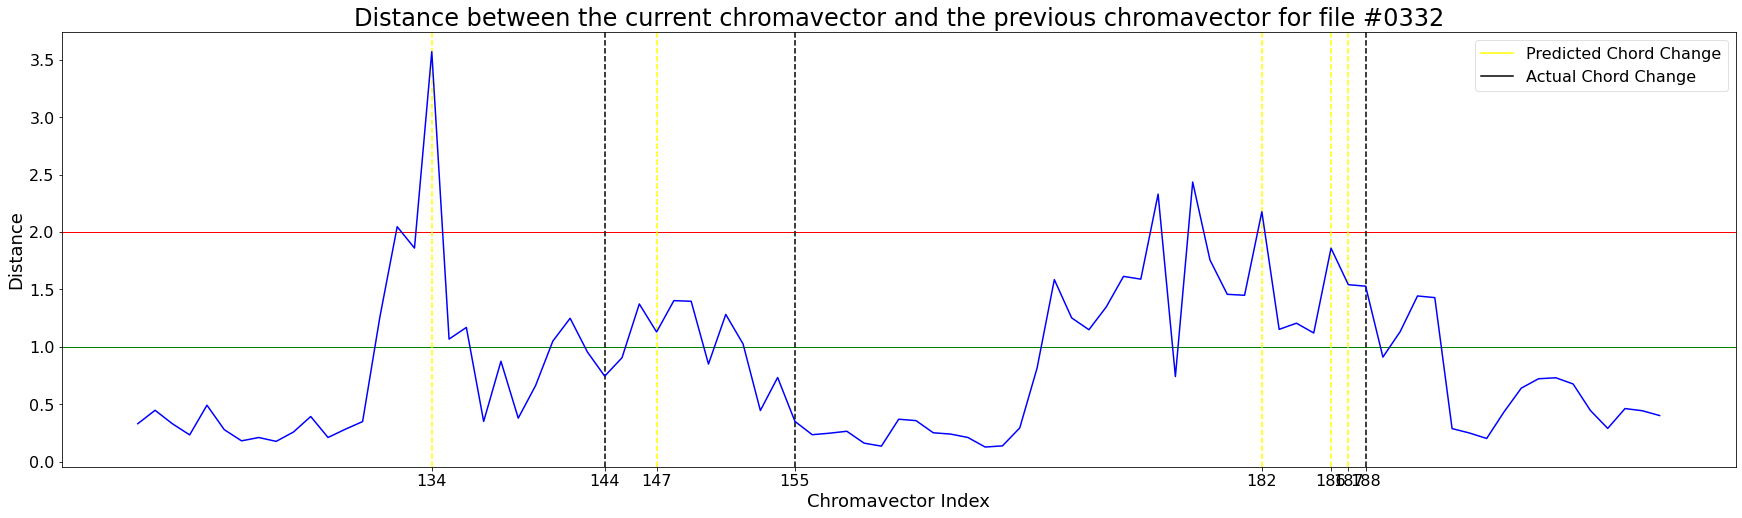

In [ ]:
plot_chord_change('0332', Chord_Extractor_MLP_ver5, viterbi = True, ccs = False, cut = [0.02, 0.035])

Predicted chord change : {137: (1, 15), 150: (15, 6), 189: (6, 1)}
   Actual chord change : {144: (1, 15), 155: (15, 6), 188: (6, 1)}


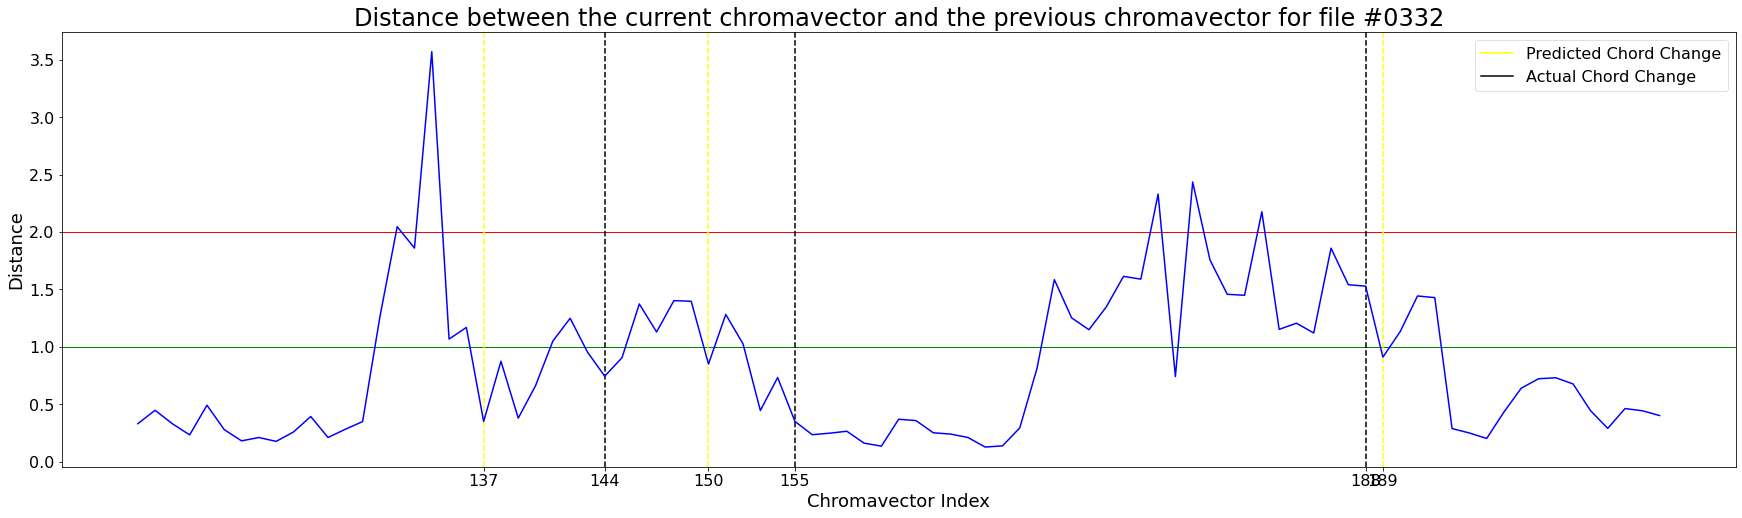

In [ ]:
plot_chord_change('0332', Chord_Extractor_MLP_ver5, viterbi = True, ccs = True, cut = [0.02, 0.035])

# Validation Accuracy of MVC models vs CSS Threshold & Sampling Number

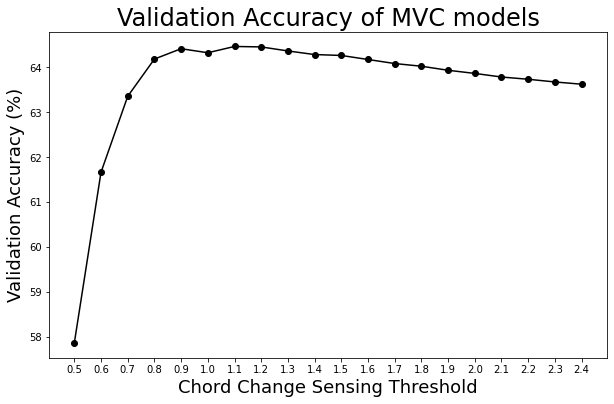

In [ ]:
Thresholds = np.arange(5, 25) / 10
accuracy = [57.86, 61.66, 63.35, 64.18, 64.41, 64.32, 64.46, 64.45, 64.36, 64.28, 64.26, 64.17, 64.08, 64.02, 63.93, 63.86, 63.78, 63.73, 63.67, 63.62]
fig = plt.figure(figsize=(10, 6))
plt.plot(Thresholds, accuracy, color = 'black', marker = 'o')
plt.xlabel('Chord Change Sensing Threshold', fontsize=18)
plt.xticks(Thresholds)
plt.ylabel('Validation Accuracy (%)', fontsize=18)
plt.title('Validation Accuracy of MVC models', fontsize=24)
plt.show()

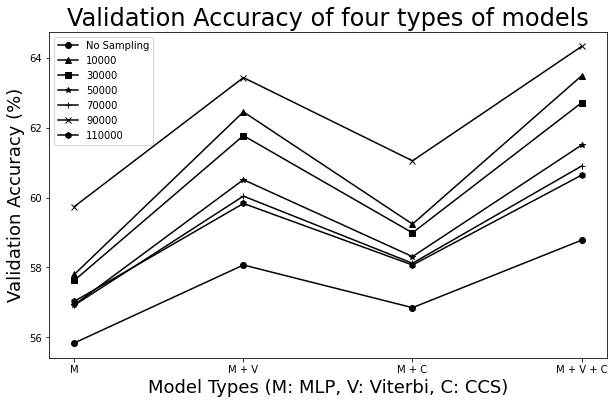

In [ ]:
Model_Types = np.arange(4)
accuracy = [[55.84, 58.07, 56.85, 58.78], 
            [57.80, 62.45, 59.24, 63.48],
            [57.63, 61.77, 58.99, 62.71],
            [56.93, 60.51, 58.31, 61.50],
            [56.92, 60.04, 58.12, 60.90],
            [59.74, 63.43, 61.05, 64.32],
            [57.03, 59.83, 58.07, 60.64]]

fig = plt.figure(figsize=(10, 6))
plt.plot(Model_Types, accuracy[0], color = 'black', marker = 'o', label = 'No Sampling')
plt.plot(Model_Types, accuracy[1], color = 'black', marker = '^', label = '10000')
plt.plot(Model_Types, accuracy[2], color = 'black', marker = 's', label = '30000')
plt.plot(Model_Types, accuracy[3], color = 'black', marker = '*', label = '50000')
plt.plot(Model_Types, accuracy[4], color = 'black', marker = '+', label = '70000')
plt.plot(Model_Types, accuracy[5], color = 'black', marker = 'x', label = '90000')
plt.plot(Model_Types, accuracy[6], color = 'black', marker = 'h', label = '110000')
plt.xlabel('Model Types (M: MLP, V: Viterbi, C: CCS)', fontsize=18)
plt.xticks(Model_Types, ['M', 'M + V', 'M + C', 'M + V + C'])
plt.ylabel('Validation Accuracy (%)', fontsize=18)
plt.title('Validation Accuracy of four types of models', fontsize=24)
plt.legend()
plt.show()

# Test Accuracy

In [ ]:
print("Version 5 Test Accuracy:", end = ' ')
check_accuracy_Viterbi_CCS(test_files, Chord_Extractor_MLP_ver5)
print()

Version 5 Test Accuracy: 

100%|██████████| 59/59 [01:57<00:00,  1.99s/it]

Got 160547 / 252085 correct (63.69) 


In [ ]:
for file in test_files:
  print("file #{}: ".format(file), end = ' ')
  check_accuracy_file(file, Chord_Extractor_MLP_ver5, viterbi =  True, ccs =  True)
  print()

file #1220:  49.42% 
file #0355:  80.27% 
file #0782:  66.89% 
file #0839:  72.86% 
file #0615:  53.78% 
file #0290:  78.09% 
file #0061:  66.46% 
file #0623:  87.38% 
file #1045:  80.30% 
file #0805:  68.94% 
file #0066:  79.20% 
file #0454:  63.78% 
file #0162:  55.29% 
file #0041:  66.73% 
file #1041:  83.42% 
file #0660:  69.21% 
file #0748:  69.41% 
file #0072:  76.34% 
file #0111:  39.65% 
file #1094:  81.93% 
file #1142:  57.88% 
file #1239:  88.25% 
file #1011:  85.08% 
file #0846:  60.75% 
file #0184:  83.99% 
file #1194:  80.81% 
file #1020:  36.25% 
file #0948:  87.57% 
file #0596:  64.68% 
file #0475:  73.28% 
file #0700:  57.80% 
file #1132:  63.32% 
file #0685:  73.51% 
file #1168:  77.82% 
file #0721:  68.70% 
file #0012:  78.65% 
file #0847:  64.04% 
file #0320:  48.80% 
file #0206:  77.06% 
file #1056:  40.76% 
file #1110:  41.16% 
file #0481:  48.25% 
file #1245:  83.05% 
file #0863:  77.83% 
file #1087:  2.07% 
file #0571:  41.89% 
file #1051:  61.17% 
file #0791:  8

In [ ]:
test_accuracy = [49.42, 80.27, 66.89, 72.86, 53.78, 78.09, 66.46, 87.38, 80.30, 68.94, 79.20, 63.78, 55.29, 66.73, 83.42, 69.21, 69.41, 76.34, 39.65, 81.93, 57.88, 88.25, 85.08, 60.75, 83.99, 80.81, 36.25, 87.57, 64.68, 73.28, 57.80, 63.32, 73.51, 77.82, 68.70, 78.65, 64.04, 48.80, 77.06, 40.76, 41.16, 48.25, 83.05, 77.83, 2.07, 41.89, 61.17, 87.60, 60.02, 39.70, 17.84, 46.91, 58.90, 49.04, 68.81, 77.83, 68.94, 34.13, 70.01]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

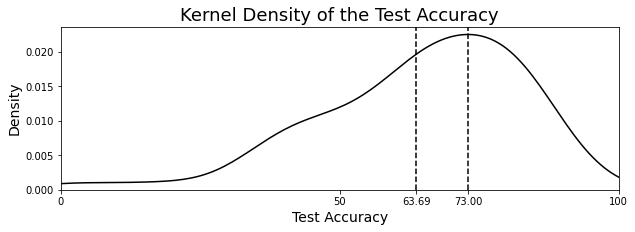

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(10, 3))
plt.xlabel('Test Accuracy', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Kernel Density of the Test Accuracy', fontsize=18)
plt.xticks(np.array([0, 50, 63.69, 73.00, 100]), ['0', '50', '63.69', '73.00', '100'])
plt.xlim(0, 100)
plt.axvline(x=63.69, ls='--', color = 'black')
plt.axvline(x=73.00, ls='--', color = 'black')
sns.kdeplot(test_accuracy, color="black")